<h1 style='text-align: center;'>Hotel Booking Demand: Part 2</h1>
<h5 style='text-align: center;'>Created by: Umam Ihsanil Ummah & Garudapaksi Yusuf</h5>

In [429]:
# Importing libraries for data analysis
import pandas as pd
import matplotlib.pyplot as plt
from phik import phik_matrix

# Loading cleaned dataset
data = pd.read_csv(filepath_or_buffer='hotel_bookings_cleaned.csv')

# Copying dataset
df = data.copy()\
         .drop(columns=['adults', 'children', 'babies', 'stays_in_weekend_nights', 'stays_in_week_nights', 'revenue']) # Dropping columns

Notes:
* Copying dataset to avoid chained indexing.
* Columns/variables that were ...

---

# **Data Preprocessing**

## Correlation

### Numerical Variables

In [430]:
# Listing numerical columns
numerical_target_vars = df.select_dtypes(include='number')

# Setting runtime configuration
plt.rcParams["image.cmap"] = 'YlGnBu'

# Computing pairwise correlation of numerical variables
numerical_target_vars.corr(method='spearman', # Using Spearman's method for non-parametric variables
                           numeric_only=True)\
                     .style.background_gradient(cmap=None).format(formatter='{:.3f}') # Adding colors & rounding numbers displayed

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,total_stays_in_nights,total_guests,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000,0.225,0.087,-0.000,0.005,0.103,0.101,-0.090,0.126,-0.101,-0.125,0.015,0.141,-0.186,-0.129
lead_time,0.225,1.000,0.136,0.097,0.012,0.455,0.213,-0.220,0.000,-0.191,0.056,0.098,0.101,-0.110,0.061
arrival_date_year,0.087,0.136,1.000,-0.516,-0.011,0.022,0.066,0.023,-0.109,0.033,-0.005,-0.029,0.189,-0.041,0.066
arrival_date_week_number,-0.000,0.097,-0.516,1.000,0.088,0.046,0.032,-0.039,0.047,-0.047,0.018,-0.000,0.114,0.010,0.044
arrival_date_day_of_month,0.005,0.012,-0.011,0.088,1.000,-0.016,0.011,-0.004,-0.004,-0.001,0.005,0.012,0.019,0.008,-0.003
total_stays_in_nights,0.103,0.455,0.022,0.046,-0.016,1.000,0.195,-0.179,-0.039,-0.163,0.047,-0.010,0.092,-0.063,0.064
total_guests,0.101,0.213,0.066,0.032,0.011,0.195,1.000,-0.206,-0.088,-0.223,-0.021,-0.044,0.421,0.032,0.172
is_repeated_guest,-0.090,-0.220,0.023,-0.039,-0.004,-0.179,-0.206,1.000,0.250,0.825,0.013,-0.014,-0.177,0.071,-0.011
previous_cancellations,0.126,0.000,-0.109,0.047,-0.004,-0.039,-0.088,0.250,1.000,0.247,-0.017,0.021,-0.081,-0.008,-0.009
previous_bookings_not_canceled,-0.101,-0.191,0.033,-0.047,-0.001,-0.163,-0.223,0.825,0.247,1.000,0.019,-0.005,-0.167,0.087,-0.002


Notes:
* Using runtime configuration to change the visual appearance of plots in this section.
* If there are no repeated/duplicated data values, a perfect Spearman's correlation (ρ) of +1 or −1 occurs when each of the variables is a perfect monotone (linear) function of the other. If Y variable tends to increase when X variable increases, the Spearman correlation coefficient is positive —and vice versa for negative coefficient.
* Pairing of variables with high positive correlation value (ρ-value of 0.66 - 1) are:
    * `is_repeated_guest` & `previous_bookings_not_canceled` (ρ = 0.825)

Highly correlated variables provide redundant information and reducing prediction model's ability to generalize (causing overfitting). Therefore, **variable which causes this correlation will not be used: `previous_bookings_not_canceled`**.

* Also to reduce the number of variables while minimizing loss of data information used in modeling, several columns which provide informations regarding the arrival date of customers (namely `arrival_date_year`, `arrival_date_month`, and `arrival_date_day_of_month`) will be recategorized (as shown below).

In [431]:
# Converting columns with 'datetime' information in dataset
df['arrival_date'] = pd.to_datetime(arg={'year': df.arrival_date_year,
                                         'month': pd.to_datetime(arg=df.arrival_date_month, format='%B').dt.month,
                                         'day': df.arrival_date_day_of_month})

# Converting 'datetime' column to 'dayofweek'
df['day_of_week'] = df['arrival_date'].dt.dayofweek

# Inserting new value in 'arrival_date_year' index location
df.insert(loc=df.columns.get_loc(key='arrival_date_year'), 
          column='arrival_day_type', 
          value=df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')) # Defining function to denotes 'Weekday' and 'Weekend'

# Dropping redundant columns
df.drop(columns=['arrival_date', 'day_of_week', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month'], inplace=True)

# Verifying process
with pd.option_context('display.max_columns', None):
    display(df.sample(n=5))

,hotel,is_canceled,lead_time,arrival_day_type,arrival_date_month,total_stays_in_nights,total_guests,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
43259,City Hotel,1,100,Weekday,September,4,2,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient-Party,100.00,0,0,1,2016-08-23
60896,City Hotel,0,127,Weekday,April,4,1,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient-Party,80.00,0,0,Check-Out,2016-05-02
66340,City Hotel,0,171,Weekend,August,4,3,BB,NOR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,114.75,0,2,Check-Out,2016-08-10
43979,City Hotel,1,60,Weekday,October,1,2,SC,CN,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,80.10,0,2,1,2016-08-29
24237,Resort Hotel,0,43,Weekday,November,4,2,BB,FRA,Offline TA/TO,TA/TO,0,0,0,A,D,0,No Deposit,0,Transient,35.00,1,1,Check-Out,2016-11-05


Notes:
* inserting...
* `dayofweek` is property from Pandas which provides information regarding the day of the week from a `datetime (dt)` values, with `Monday = 0` and `Sunday = 6`
    * By using this, user can infer `Weekday` days by selecting `dt` values from 0 to 4 (Monday to Friday), and `Weekend` days from 5 to 6 (Saturday and Sunday).
* `arrival_date_week_number` will be redundant with this new column and will be dropped.
* pengaruh bulan dari eda + limitation from year

### Categorical Variables

In [432]:
# Selecting categorical variables as subset
categorical_target_vars = df.select_dtypes(include='object')\
                            .combine_first(other=df[['is_canceled']]) # Combining subset with target variable

# Computing pairwise correlation of categorical & target variables
phik_matrix(df=categorical_target_vars, 
            # Applying target as interval column/variable
            interval_cols='is_canceled')\
            .style.background_gradient(cmap=None).format(formatter='{:.3f}')

,arrival_date_month,arrival_day_type,assigned_room_type,country,customer_type,deposit_type,distribution_channel,hotel,is_canceled,market_segment,meal,reservation_status,reservation_status_date,reserved_room_type
arrival_date_month,1.000,0.086,0.095,0.262,0.213,0.114,0.125,0.076,0.108,0.168,0.147,0.151,0.977,0.110
arrival_day_type,0.086,1.000,0.037,0.054,0.024,0.008,0.072,0.048,0.019,0.086,0.064,0.007,0.232,0.054
assigned_room_type,0.095,0.037,1.000,0.139,0.175,0.135,0.146,0.477,0.120,0.171,0.346,0.148,0.219,0.940
country,0.262,0.054,0.139,1.000,0.230,0.226,0.316,0.445,0.235,0.401,0.232,0.322,0.505,0.163
customer_type,0.213,0.024,0.175,0.230,1.000,0.053,0.111,0.094,0.193,0.453,0.194,0.097,0.493,0.152
deposit_type,0.114,0.008,0.135,0.226,0.053,1.000,0.049,0.034,0.100,0.304,0.034,0.342,0.581,0.081
distribution_channel,0.125,0.072,0.146,0.316,0.111,0.049,1.000,0.111,0.123,0.772,0.115,0.147,0.333,0.224
hotel,0.076,0.048,0.477,0.445,0.094,0.034,0.111,1.000,0.108,0.164,0.467,0.043,0.260,0.408
is_canceled,0.108,0.019,0.120,0.235,0.193,0.100,0.123,0.108,1.000,0.206,0.082,1.000,0.367,0.072
market_segment,0.168,0.086,0.171,0.401,0.453,0.304,0.772,0.164,0.206,1.000,0.231,0.234,0.477,0.210


Notes:
* Phi_K (ϕk) library is used to compute correlation between categorical and interval variables.
    * Based on Pearson's chi-squared contingency test —a hypothesis test for independence between two or more variables.
    * `is_canceled` is added into this analysis because we would want to find the association between categorical variables and the target of this prediction model, and also applied as interval variable because the difference between values in this column (`1` or `0`) is meaningful.
    * Phi_K correlation matrix drops missing value from the data to calculate the correlation coefficient by default (parameter `dropna` already set to `True`).
    * It captures any non-linear relationship between variables, and has a built-in noise reduction against statistical fluctuations or outliers (parameter `noise_correction` also set to `True` by default).
    * Correlation coefficient value is between 0 and 1, hence no indication of relationship direction between variables.
* Variable pairings with high correlation value (ϕk value of 0.66 - 1) are:
    * `assigned_room_type` and `reserved_room_type` (ϕk = `0.940`)
    * `is_canceled` and `reservation_status` (ϕk = `1.000`; perfectly correlated)
    * `market_segment` and `distribution_channel` (ϕk = `0.772`)
    * ...
* ...

* limitasi phik

In [433]:
# Dropping correlated variables from dataset
df.drop(columns=['previous_bookings_not_canceled', 'assigned_room_type', 'reservation_status', 'reservation_status_date'], inplace=True)

# Detecting duplicated data (after subsetting variables)
df[df.duplicated()]

,hotel,is_canceled,lead_time,arrival_day_type,arrival_date_month,total_stays_in_nights,total_guests,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
403,Resort Hotel,0,57,Weekday,July,2,2,FB,PRT,Groups,Direct,0,0,A,0,No Deposit,0,Transient-Party,107.00,0,0
406,Resort Hotel,0,57,Weekday,July,2,2,FB,PRT,Groups,Direct,0,0,A,0,No Deposit,0,Transient,107.00,0,0
411,Resort Hotel,0,57,Weekday,July,2,1,FB,PRT,Groups,Direct,0,0,A,1,No Deposit,0,Transient-Party,94.00,0,0
1296,Resort Hotel,1,57,Weekday,August,4,3,HB,PRT,Offline TA/TO,TA/TO,0,0,A,0,No Deposit,0,Transient,133.00,0,1
1912,Resort Hotel,1,81,Weekend,September,7,2,BB,PRT,Online TA,TA/TO,0,0,A,0,No Deposit,0,Transient,66.29,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86337,City Hotel,0,176,Weekday,August,2,2,HB,DEU,Direct,Direct,0,0,A,1,No Deposit,0,Transient,135.00,0,1
86483,City Hotel,0,142,Weekday,August,1,2,BB,USA,Direct,Direct,0,0,D,1,No Deposit,0,Transient,150.00,0,2
86581,City Hotel,0,457,Weekday,August,2,2,HB,DEU,Offline TA/TO,TA/TO,0,0,A,1,No Deposit,0,Transient-Party,122.40,0,1
86836,City Hotel,0,213,Weekday,August,4,1,HB,PRT,Groups,TA/TO,0,0,A,1,No Deposit,0,Transient-Party,104.00,0,0


Notes:
* Subsetting variables may re-raise data duplication issue
    * Data points which are different from each other in complete dataset may become similar if certain variables are dropped
* same with previous section, drop to avoid overfitting
* **These categorical variables (excluding `is_canceled`) will be the features used in prediction modeling**.

In [434]:
# Handling duplicated data
df.drop_duplicates(inplace=True)

# ...
pd.DataFrame(data={'Dataset (Original)': data.shape,
                   'Dataset (Modeling)': df.shape,
                   'Dropped Data': (data.shape[0] - df.shape[0], data.shape[1] - df.shape[1])},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Dataset (Original),86940,33
Dataset (Modeling),85154,21
Dropped Data,1786,12


## Outlier

In [435]:
# Defining function for detecting outlier
def detect_outlier(variable):
    Q1, Q3 = df[variable].quantile(q=0.25), df[variable].quantile(q=0.75)
    IQR = Q3 - Q1
    lower_boundary, upper_boundary = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = df.loc[(df[variable] <  (lower_boundary)) | (df[variable] > (upper_boundary))]
    return outliers

Notes:

* Outlier detection uses adjusted box-plot method:
    * Used for data with non-normal (skewed) distribution.
    * Q1 and Q3 are defined as 25th and 75th percentile of the data, respectively.
    * Interquartile range (IQR) as the distance between Q1 and Q3.
    * Boundaries for this method are defined as 1.5 of IQR for both side, and
    * Data points outside these boundaries are flagged as outliers.

In [436]:
# Selecting numeric variables
numeric_vars = df.select_dtypes(include='number')

# Showing summary of outlier in numerical variables
pd.DataFrame(data={'numeric_variables': numeric_vars.columns,
                   'n': [detect_outlier(var).shape[0] for var in numeric_vars],
                   '%': [round(number=detect_outlier(var).shape[0] / df.shape[0] * 100, ndigits=2) for var in numeric_vars],
                   'sample': [sorted(detect_outlier(var)[var].unique()) for var in numeric_vars],
                   'min': [detect_outlier(var)[var].min() for var in numeric_vars],
                   'max': [detect_outlier(var)[var].max() for var in numeric_vars]})

,numeric_variables,n,%,sample,min,max
0,is_canceled,0,0.00,[],NaN,NaN
1,lead_time,2357,2.77,"[295, 296, 297, 298, 299, 300, 301, 302, 303, ...",295.00,737.0
2,total_stays_in_nights,2989,3.51,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",10.00,57.0
3,total_guests,29236,34.33,"[0, 1, 3, 4, 5, 6, 10, 12, 20, 26, 27, 40, 50,...",0.00,55.0
4,is_repeated_guest,3273,3.84,[1],1.00,1.0
5,previous_cancellations,1613,1.89,"[1, 2, 3, 4, 5, 6, 11, 13, 14, 19, 21, 24, 25,...",1.00,26.0
6,booking_changes,15540,18.25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.00,21.0
7,days_in_waiting_list,756,0.89,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.00,391.0
8,adr,2432,2.86,"[228.21, 228.3, 228.32, 228.33, 228.5, 228.53,...",228.21,5400.0
9,required_car_parking_spaces,7166,8.42,"[1, 2, 3, 8]",1.00,8.0


Notes:

* Depending on the context, outliers either (1) deserve special attention or (2) should be completely ignored. 
    1. Take an example of `lead_time`: if unusual number of days are observed, it may be a good idea to pay extra attention to them and figure out whether these values are sensible or not (based on the data description). So in instances like these, it is useful to investigate the outlier values and handling them accordingly.
    2. If outliers are however, introduced due to mechanical error, measurement error or anything else that cannot be generalized, it is a good idea to remove these outliers before feeding the data to the modeling algorithm —because some algorithms are sensitive to outliers.

| Variable | Insights |
| --- | --- |
| `lead_time` | Customer may books from a distant point in time; i.e. books at year `x` to arrive in Hotel at year `x + 2`, hence `lead_time` = `~730` |
| `total_stays_in_nights` | Customer may books to stay for `57` days |
| `total_guests` | Customer may books for a group of `50` guests |
|  | Domain knowledge indicates that Customer may not input `0` number of guest in their reservation process |
| `is_repeated_guest` | Variable's data type is representing `bool` in reality (either customer is a repeating guest or not), hence `1` is not considered an outlier |
| `previous_cancellations` | Customer may have a history of cancelled booking up to `26` times at Hotel |
| `booking_changes` | Customer may have a history of modifying their booking information up to `21` times, even if such booking is cancelled afterwards |
| `days_in_waiting_list` | Customer may waits up to `~365` days (1 year) until their reservation is approved by Hotel? |
| `adr` | Indicates that Hotel's Average Daily Rate may fluctuates up to `5.400` monetary value per day |
| `required_car_parking_spaces` | Customer may require up to `8` car parking spaces in their booking; i.e. for a group of guests |
| `total_of_special_requests` | Customer may require up to `5` special requests in their booking |

Notes:

* `previous_cancellations` tinggi (outlier) belum tentu `is_canceled`, karena nilai median dari bivariat `previous_cancellations` dengan `is_canceled` adalah 0
    * begitu pula dengan `booking_changes`
    * begitu pula dengan `days_in_waiting_list`?
* For sensible outliers, **there are several options to handle outlier —which will be experimented upon in modeling section—** namely:
    * Scaling
        * When the distribution of the variable is skewed, it is better to scale using the median and quantiles method, which is more robust to outliers.
    * Transformation
        * Since this analysis is in the context of a business setting, it is better to use the original variable without transformation to train the model, as this would represent a simpler situation at the time of asking developers to implement the model in real life, and also it will be easier to interpret.
    * Binning
        * Equal frequency binning is straightforward to implement, and by spreading the values of the observations more evenly, it may help boost the model's performance. On the other hand, arbitrary binning (including equal width and domain knowledge binning) may also disrupt the relationship with target.
        * Therefore, whenever possible, it will bring value to examine whether such type of binning is the right strategy, and it will depend on the variable and the model that will be used to make the prediction.
* total_guests = 0...

* `stays_in_nights` berarti checkout malam; bisa aja guest checkout siang sehingga `stays_in_nights` = 0
    * taruh mana ini ya wkwk

In [437]:
# Selecting outlier in dataset
df[df.total_guests == 0]

,hotel,is_canceled,lead_time,arrival_day_type,arrival_date_month,total_stays_in_nights,total_guests,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
2087,Resort Hotel,0,1,Weekday,October,3,0,SC,PRT,Corporate,Corporate,0,0,A,1,No Deposit,0,Transient-Party,0.00,0,0
2223,Resort Hotel,0,0,Weekday,October,0,0,SC,PRT,Corporate,Corporate,0,0,A,0,No Deposit,0,Transient,0.00,0,0
2803,Resort Hotel,0,36,Weekday,November,3,0,SC,ESP,Groups,TA/TO,0,0,A,0,No Deposit,0,Transient-Party,0.00,0,0
3090,Resort Hotel,0,165,Weekday,December,5,0,SC,PRT,Groups,TA/TO,0,0,A,1,No Deposit,122,Transient-Party,0.00,0,0
3098,Resort Hotel,0,165,Weekday,December,6,0,SC,PRT,Groups,TA/TO,0,0,A,1,No Deposit,122,Transient-Party,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83272,City Hotel,0,107,Weekday,June,3,0,BB,CHE,Online TA,TA/TO,0,0,A,1,No Deposit,0,Transient,100.80,0,0
83324,City Hotel,0,1,Weekday,June,1,0,SC,PRT,Complementary,Direct,0,0,E,0,No Deposit,0,Transient,0.00,1,1
84258,City Hotel,0,44,Weekend,July,2,0,SC,SWE,Online TA,TA/TO,0,0,A,2,No Deposit,0,Transient,73.80,0,0
84514,City Hotel,0,2,Weekend,July,7,0,SC,RUS,Online TA,TA/TO,0,0,A,1,No Deposit,0,Transient-Party,22.86,0,1


In [438]:
# Filtering outlier from dataset
df = df[df.total_guests != 0]

# ...
pd.DataFrame(data={'Dataset (Original)': data.shape,
                   'Dataset (Modeling)': df.shape,
                   'Dropped Data': (data.shape[0] - df.shape[0], data.shape[1] - df.shape[1])},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Dataset (Original),86940,33
Dataset (Modeling),84996,21
Dropped Data,1944,12


## Cardinality

In [439]:
# Selecting categorical variables
categorical_vars = df.select_dtypes(include='object')

# Showing summary of cardinality in categorical variables
pd.DataFrame(data={'categorical_columns': categorical_vars.columns,
                   'unique (n)': categorical_vars.nunique(dropna=False).values,
                   'unique_sample': [df[var].unique() for var in categorical_vars],
                   'rare_label (n)': [sum(df[var].value_counts(normalize=True, dropna=False) < 0.05) for var in categorical_vars],
                   'rare_label_sample': [df[df[var].map(arg=df[var].value_counts(normalize=True, dropna=False) < 0.05)][var].unique() 
                                         for var in categorical_vars]})

,categorical_columns,unique (n),unique_sample,rare_label (n),rare_label_sample
0,hotel,2,"[Resort Hotel, City Hotel]",0,[]
1,arrival_day_type,2,"[Weekday, Weekend]",0,[]
2,arrival_date_month,12,"[July, August, September, October, November, D...",0,[]
3,meal,4,"[BB, FB, HB, SC]",1,[FB]
4,country,177,"[PRT, GBR, USA, ESP, IRL, FRA, ROU, NOR, OMN, ...",172,"[USA, IRL, ROU, NOR, OMN, ARG, POL, BEL, CHE, ..."
5,market_segment,7,"[Direct, Corporate, Online TA, Offline TA/TO, ...",3,"[Corporate, Complementary, Aviation]"
6,distribution_channel,5,"[Direct, Corporate, TA/TO, Undefined, GDS]",2,"[Undefined, GDS]"
7,reserved_room_type,9,"[C, A, D, E, G, F, H, L, B]",6,"[C, G, F, H, L, B]"
8,deposit_type,3,"[No Deposit, Refundable, Non Refund]",2,"[Refundable, Non Refund]"
9,customer_type,4,"[Transient, Contract, Transient-Party, Group]",2,"[Contract, Group]"


Notes:

* The number of different (unique) labels within a categorical variable is known as cardinality. A high number of labels within a variable is known as high cardinality.
    * Also different categories appear in the dataset with different frequencies. Some labels appear a lot in the dataset, whereas some other labels appear only in a few number of observations —hence called rare labels.
* High cardinality & rare values may pose the following problems:
    * A big number of labels (whether frequent or infrequent) within a variable may introduce noise with little, if any, information, therefore making machine learning model prone to over-fit.
    * Some of the labels may only be present in the training data set, but not in the test set, therefore machine learning algorithm may over-fit to the training set.
    * Contrarily, some labels may appear only in the test set, therefore leaving the machine learning algorithm unable to perform a calculation over the new (unseen) observation —a case of model underfit.
    * In particular, tree-based model can be biased towards variable with lots of labels. Thus, their performance may be affected by high cardinality.
    * Sometimes rare values are indeed important. If we are building a model to predict hotel booking cancellation, which are —by nature— rare compared to successful booking, then a rare value in a certain variable may be very predictive. This rare value could be telling us that the observation is most likely a cancelled booking, and it would be best not to ignore it.
* High number of cardinality in dataset are detected in `country`, while rare labels are found in all variables except `hotel` and ...
* Cardinality and rare label issues ... : 
    1. reduce by recategorize, either all categories or only specific labels deemed rare       
        * Even though `FB` value in `meal` variable is detected as rare label or infrequent category... 
    2. use the labels as-is (without any modifications)


## Imbalanced Data

Notes:

* random undersampling-oversampling ada pros cons nya

---

# Modeling

## Model Environment

In [440]:
# Importing libraries for model environment setup
from sklearn.model_selection import train_test_split
from pycaret.internal.preprocess.transformers import TransformerWrapper
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.preprocessing import OneHotEncoder

In [441]:
# Setting arbitrary number to 'random_state'
random_state_ = 1

# Splitting dataset into dataframes for training and testing
df_train, df_test = train_test_split(df, random_state=random_state_, stratify=df.is_canceled)

# Showing dataframes' summary
display(pd.DataFrame(data={'dataset': ['df_train', 'df_test'],
                   'row (n)': [df_train.shape[0], df_test.shape[0]],
                   'row (%)': [df_train.shape[0] / df.shape[0] * 100, df_test.shape[0] / df.shape[0] * 100],
                   'column (n)': [df_train.shape[1], df_test.shape[1]]}))

display(pd.DataFrame(data={'df_train': round(number=df_train.is_canceled.value_counts(normalize=True) * 100, ndigits=3),
                   'df_test': round(number=df_test.is_canceled.value_counts(normalize=True) * 100, ndigits=3)}).T)

,dataset,row (n),row (%),column (n)
0,df_train,63747,75.0,21
1,df_test,21249,25.0,21


,0,1
df_train,72.184,27.816
df_test,72.182,27.818


Notes:
* Splitting is done to partition dataset into:
    * Training set (`df_train`), which is used to train the machine learning model. This is the core dataset where the model learns to understand patterns and relationship in the data.
    * Test set (`df_test`), which provides a basis for evaluating the model's performance on unseen data.
        * Even though `df_test` originally comes from the same `df` dataset, this set is not used in training the model, and its target (`is_canceled`) will be hidden in the later stage of this modeling section.
        * This dataset is crucial for assessing the model's ability to generalize into unknown data.
* `random_state` is required to control the random sampling process applied to dataset before splitting into `df_train` and `df_test` —including data for validation, which will be implemented later on.
    * This is done so that the result of splitting (rows, columns, and all their values/data points/observations) will be identical for each time the programming code in this modeling section is called.
* By applying `stratify` parameter, the dataset is sampled in a stratified fashion, to ensure that relative class/target `is_canceled` frequencies is approximately preserved in each train and validation fold.
    * tapi masih imbalance...

In [442]:
# Creating custom pipeline for modeling
pipeline = [
    ('ordinal', TransformerWrapper(
        transformer=OrdinalEncoder(mapping=[{'col': 'meal', 
                                             'mapping': {'SC': 0, 
                                                         'BB': 1, 
                                                         'HB': 2, 
                                                         'FB': 3}}]))),
    ('binary', TransformerWrapper(
        include=['country'], 
        transformer=BinaryEncoder())),
    ('onehot', TransformerWrapper(
        include=[var for var in categorical_vars.drop(columns=['meal', 'country'])], 
        transformer=OneHotEncoder(sparse_output=False, handle_unknown='ignore')))]

Notes:

* `TransformerWrapper` used as wrapper class to input preprocessing transformer (encoder, scaler, etc.) into PyCaret environment.
* `meal` encoded with `OrdinalEncoder` because categories in this variable can be meaningfully ordered from the type of Hotel meal booked: ` SC < BB < HB < FB`.
* `country` encoded with `BinaryEncoder` because, without any modifications to its original categories, this variable contains a large amount of cardinality
    * Encoding this variable with `OneHotEncoder` would result in a large feature space, and further slowing down the training time of the model
    * `BinaryEncoder` is appropriate to use in this situation; this encoding scheme uses binary value to split a categorical feature into several columns
        * In the case of `country`, 177 categories in this variable will be converted to its binary value of 10110001 —a value with 8 digits. This binary is then used to split this variable into 8 columns.
        * Each categories in this variable will be converted to numerical (using ordinal encoding scheme) and then transformed to binary value. Each binary value would then be plotted accordingly to these 8 columns.
* Other categorical variables in dataset are encoded with `OneHotEncoder`:
    * ...`distribution_channel`, `reserved_room_type`, `deposit_type`, and `customer_type`, because these columns contain a small amount of cardinality.
    * Encoding/replacing these variables to boolean variables of 1 and 0 would still relatively increase the feature space (number of variables used in model training), but not to a large degree.
    * `handle_unknown` parameter applied to `ignore` unknown categories found in the encoding process.
        * After splitting the dataset, certain categories may be found in `df_train` but not in `df_test`, for example.
        * By using this parameter, categories only encountered in `df_test` will all be encoded to zeros.


## Model Experimentation

### Experiment #0: Basic Model

In [443]:
# Importing library for experiment #0
from pycaret.classification import *

# Defining keyword arguments for PyCaret setup
kwargs = {
    'data': df_train,
    'target': 'is_canceled',
    'preprocess': False, # Disabling PyCaret's in-built preprocessing pipeline
    'session_id': random_state_, # Using defined random state for train-validation splitting
    'ignore_features': 'market_segment'}

# Initializing model training environment
experiment0 = setup(**kwargs, 
                     custom_pipeline=pipeline) # Implementing custom pipeline

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(63747, 21)"
4,Transformed data shape,"(63747, 57)"
5,Transformed train set shape,"(44622, 57)"
6,Transformed test set shape,"(19125, 57)"
7,Ignore features,14
8,Numeric features,10
9,Categorical features,9


Notes:

* ignore features berasal dari...
* PyCaret uses Stratified K-Fold as default method in cross-validation (parameter `fold_strategy` already set to `stratifiedkfold`).
    * By splitting training set into 'K' smaller set as the validation dataset, model performance reported by K-fold cross-validation is then the average of the values computed in the 'loop' (training model using train dataset, after which the evaluation is done on the validation set by iterating them 'K' number of times).
    * As can be seen above, original dataset (`df_train`) is transformed and splitted again into train and test set. Training dataset will be the one used in training the model, while test set acts as the validation dataset (differs with `df_test` which will be used in model prediction).

In [444]:
# Validating usage of custom pipeline
experiment0.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['hotel',
                                                                                                    'arrival_day_type',
                                                                                                    'arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposi...
                                                                   include=['hotel',
                                                                            'arrival_day_type',
                                                                            'arrival_date_month',
                                                                            'market_segment',
                                                                            'distribution_channel',
                                                                            'reserved_room_type',
                                                                            'deposit_type',
                                                                            'customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop=None,
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='ignore',
                                                                                             max_categories=None,
                                                                                             min_frequency=None,
                                                                                             sparse='deprecated',
                                                                                             sparse_output=False))))],
         verbose=False)

In [445]:
# Validating feature transformation using custom pipeline
X_train_transformed0 = experiment0.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed0)

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,total_stays_in_nights,total_guests,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
25060,0.0,1.0,41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,2,1,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,43.200001,0,0
11976,0.0,1.0,190,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,2,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,110.699997,0,1
3893,0.0,1.0,97,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,44.099998,0,1
35282,1.0,0.0,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,3,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,105.000000,0,2
3696,0.0,1.0,168,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5,2,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0,0.0,0.0,0.0,1.0,66.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49001,1.0,0.0,122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,2,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,7,0.0,0.0,1.0,0.0,190.000000,0,0
21415,0.0,1.0,190,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4,2,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,336.500000,1,1
8878,0.0,1.0,310,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7,2,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,88.199997,0,0
18747,0.0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,0,0,0,0,0,1,1,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,70.000000,0,1


Notes:

* Pipeline implemented and train-validation dataset succesfully encoded to numerical values.

In [446]:
# Importing libraries for adding custom metrics
import numpy as np
from sklearn.metrics import fbeta_score

# Defining Hotel Cost per class prediction error
false_negative = 175
false_positive = (225 + 375) / 2

# Defining function to calculate Hotel Cost
def calculate_cost(y, y_pred):
    FN = np.where((y_pred == 0) & (y == 1), false_negative, 0)
    FP = np.where((y_pred == 1) & (y == 0), false_positive, 0)
    return np.sum(a=[FN, FP])

# Adding 'F-beta' score & Hotel Cost metric
experiment0.add_metric(id='F0.5', name='F0.5', score_func=fbeta_score, beta=0.5)
experiment0.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performance of models available in PyCaret
experiment0_holdout = experiment0.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8207,0.8769,0.5647,0.7300,0.6367,0.5202,0.5279,0.6895,172462.5000,18.8190
xgboost,Extreme Gradient Boosting,0.8182,0.8730,0.5715,0.7176,0.6361,0.5170,0.5231,0.6826,176902.5000,6.8060
lightgbm,Light Gradient Boosting Machine,0.8167,0.8703,0.5456,0.7278,0.6235,0.5057,0.5149,0.6821,174810.0000,0.9470
rf,Random Forest Classifier,0.8159,0.8630,0.5416,0.7272,0.6206,0.5025,0.5121,0.6804,175355.0000,5.6970
et,Extra Trees Classifier,0.8000,0.8368,0.5274,0.6820,0.5946,0.4648,0.4717,0.6441,194395.0000,7.1040
gbc,Gradient Boosting Classifier,0.7941,0.8344,0.4115,0.7310,0.5263,0.4077,0.4353,0.6325,184327.5000,5.6750
ada,Ada Boost Classifier,0.7799,0.8084,0.4090,0.6712,0.5081,0.3770,0.3963,0.5948,202942.5000,2.1490
lr,Logistic Regression,0.7710,0.7864,0.3526,0.6674,0.4613,0.3331,0.3605,0.5662,206060.0000,6.7910
lda,Linear Discriminant Analysis,0.7654,0.7770,0.2905,0.6843,0.4076,0.2901,0.3316,0.5380,203965.0000,1.0200
ridge,Ridge Classifier,0.7622,0.0000,0.2369,0.7203,0.3563,0.2537,0.3130,0.5111,199990.0000,0.3950


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Notes:

* Hotel cost...
    * the lower the better
* `F-beta` metric with `beta=0.5`...
* PyCaret provides a collection of estimators/models accessible via `compare_models()` function, enabling its users to easily train and evaluate performance of various models, and choosing one with the best metric scores
    * Cost metric appears to be incorrectly highlighted —with the highest score chosen as the better one— even though parameter `greater_is_better=False` already applied in adding Hotel Cost as custom metric to this experimentation
* There are several considerations to be made in choosing the best model from `compare_models()` result:
    * ...
    * `Cost` score is a business-side metric, in which this modeling section is focusing on model-side metric instead.
    * training time...
    * `Dummy Classifier` makes predictions that ignore the input features, and only serves as a simple baseline to compare against other more complex classifiers. Therefore, results in this estimator may be disregarded.
    * ... will be assigned as the best model in this experimentation, and further tuned to try to increase its performance.

In [447]:
# Comparing performance of models available in PyCaret
experiment0_holdout = experiment0.compare_models(exclude='catboost')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8182,0.8730,0.5715,0.7176,0.6361,0.5170,0.5231,0.6826,176902.5000,6.4290
lightgbm,Light Gradient Boosting Machine,0.8167,0.8703,0.5456,0.7278,0.6235,0.5057,0.5149,0.6821,174810.0000,0.8900
rf,Random Forest Classifier,0.8159,0.8630,0.5416,0.7272,0.6206,0.5025,0.5121,0.6804,175355.0000,5.2860
et,Extra Trees Classifier,0.8000,0.8368,0.5274,0.6820,0.5946,0.4648,0.4717,0.6441,194395.0000,6.7430
gbc,Gradient Boosting Classifier,0.7941,0.8344,0.4115,0.7310,0.5263,0.4077,0.4353,0.6325,184327.5000,5.6280
ada,Ada Boost Classifier,0.7799,0.8084,0.4090,0.6712,0.5081,0.3770,0.3963,0.5948,202942.5000,2.1970
lr,Logistic Regression,0.7710,0.7864,0.3526,0.6674,0.4613,0.3331,0.3605,0.5662,206060.0000,6.0800
lda,Linear Discriminant Analysis,0.7654,0.7770,0.2905,0.6843,0.4076,0.2901,0.3316,0.5380,203965.0000,0.9310
ridge,Ridge Classifier,0.7622,0.0000,0.2369,0.7203,0.3563,0.2537,0.3130,0.5111,199990.0000,0.3080
dt,Decision Tree Classifier,0.7484,0.6906,0.5596,0.5470,0.5531,0.3781,0.3783,0.5494,268425.0000,0.6330


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

In [448]:
# Assigning '...' as basic model
experiment0_model = experiment0.create_model(estimator='lightgbm',
                                             return_train_score=True) # Showing cross-validation score

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:08:16
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Notes:
* Model is capable to generalize unto validation dataset
    * Indicated by non-significant difference in performance from training set to validation set.

In [449]:
# Showing best model's applied parameter
experiment0.plot_model(estimator=experiment0_model, plot='parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


Notes:

* Hyperparameter tuning will be implemented according to these applied parameters.

In [450]:
# Defining custom hyperparameter gridspace for '...'
parameters_lightgbm = {
    'learning_rate': [0.01, 0.05],
    'num_leaves': [50, 100]
}

Notes:
* potential hyperparam space for random forest are...
    * reference: [(1)](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters) [(2)](https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/)
    * berfokus pada ...
    * Algoritma *Exhaustive Grid Search* dapat digunakan untuk memaksimalkan nilai *cross validation* tersebut, dengan cara mengiterasi seluruh kandidat yang ada dalam *hyperparameter space*.
    * Namun untuk membatasi *training time*...
    * parameter yang dipilih adalah yang berhasil meningkatkan performa setelah masing-masing diiterasi

In [451]:
# Tuning model's hyperparameter
experiment0_model_tuned = experiment0.tune_model(estimator=experiment0_model, 
                                                 custom_grid=parameters_lightgbm, # Using custom gridspace for '...'
                                                 search_algorithm='grid',
                                                 optimize='F0.5',
                                                 return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Notes:
* Returned model by `tune_model()` is better performing than the given estimator/model.
    * `choose_better` parameter already set to `True` by default.
    * `optimize` parameter set to optimize model's `F0.5` score
        * ...
        * `Cost` score is a business-side metric, in which this modeling section is focusing on model-side metric instead.
* Nevertheless, model in this experiment will be used as benchmark against estimator from other experimentation.

### Experiment #1: Handling Outlier with Scaling

In [452]:
# Importing library for experiment #1
from sklearn.preprocessing import RobustScaler

# Adding 'RobustScaler' to custom pipeline
pipeline.append(
    ('robust', TransformerWrapper(
        include=[var for var in numeric_vars.drop(columns=['is_canceled', 'is_repeated_guest'])],
        transformer=RobustScaler())))

Notes:
* `RobustScaler` removes the median from included (numeric) features and scales the data according to the interquartile range (IQR)
    * Similar to implementation from previous `Outlier` section

In [453]:
# Setting experiment #1 training environment
experiment1 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(63747, 21)"
4,Transformed data shape,"(63747, 57)"
5,Transformed train set shape,"(44622, 57)"
6,Transformed test set shape,"(19125, 57)"
7,Ignore features,14
8,Numeric features,10
9,Categorical features,9


In [454]:
# Validating usage of custom pipeline
experiment1.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['hotel',
                                                                                                    'arrival_day_type',
                                                                                                    'arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposi...
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['lead_time',
                                                                            'total_stays_in_nights',
                                                                            'total_guests',
                                                                            'previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'adr',
                                                                            'required_car_parking_spaces',
                                                                            'total_of_special_requests'],
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True))))],
         verbose=False)

In [455]:
# Validating feature transformation using custom pipeline
X_train_transformed1 = experiment1.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed1)

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,total_stays_in_nights,total_guests,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
25060,0.0,1.0,-0.078947,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.0,1,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.902913,0.0,-1.0
11976,0.0,1.0,1.228070,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333333,0.0,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.189320,0.0,0.0
3893,0.0,1.0,0.412281,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,-1.0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.888349,0.0,0.0
35282,1.0,0.0,-0.385965,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.666667,1.0,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.097087,0.0,1.0
3696,0.0,1.0,1.035088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.533981,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49001,1.0,0.0,0.631579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,1.0,0.0,1.472492,0.0,-1.0
21415,0.0,1.0,1.228070,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,2.0,2,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.843042,1.0,0.0
8878,0.0,1.0,2.280702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.333333,0.0,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.174757,0.0,-1.0
18747,0.0,1.0,-0.429825,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.666667,-1.0,1,0,0,0,0,0,1,1,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.469256,0.0,0.0


Notes:
* `RobustScaler` implemented in the pipeline and train-validation dataset succesfully scaled according to each of the features' IQR.

In [456]:
# Adding custom metrics
experiment1.add_metric(id='F0.5', name='F0.5', score_func=fbeta_score, beta=0.5)
experiment1.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #1
experiment1_holdout = experiment1.compare_models(exclude='catboost')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8182,0.8730,0.5715,0.7176,0.6361,0.5170,0.5231,0.6826,176902.5000,7.1510
lightgbm,Light Gradient Boosting Machine,0.8167,0.8702,0.5457,0.7277,0.6235,0.5057,0.5149,0.6820,174822.5000,1.0450
rf,Random Forest Classifier,0.8158,0.8630,0.5411,0.7271,0.6203,0.5022,0.5118,0.6802,175400.0000,5.1270
et,Extra Trees Classifier,0.8000,0.8368,0.5274,0.6820,0.5946,0.4648,0.4717,0.6441,194395.0000,7.4530
gbc,Gradient Boosting Classifier,0.7941,0.8344,0.4115,0.7310,0.5263,0.4077,0.4353,0.6325,184327.5000,5.4020
ada,Ada Boost Classifier,0.7799,0.8084,0.4090,0.6712,0.5081,0.3770,0.3963,0.5948,202942.5000,2.2430
lr,Logistic Regression,0.7709,0.7864,0.3526,0.6670,0.4613,0.3330,0.3603,0.5660,206192.5000,1.9760
lda,Linear Discriminant Analysis,0.7654,0.7770,0.2905,0.6843,0.4076,0.2901,0.3316,0.5380,203965.0000,1.2100
ridge,Ridge Classifier,0.7622,0.0000,0.2369,0.7203,0.3563,0.2537,0.3130,0.5111,199990.0000,0.4480
knn,K Neighbors Classifier,0.7602,0.7616,0.4839,0.5832,0.5288,0.3699,0.3728,0.5601,240955.0000,2.2740


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

Notes:
* `Extreme Gradient Boosting` has the highest score in `F0.5`.
    * This model will be assigned as the best model in this experimentation, and further tuned to try to increase its performance.

In [457]:
# Assigning '...' as experimentation model
experiment1_model = experiment1.create_model(estimator='lightgbm', return_train_score=True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [471]:
# Tuning model's hyperparameter
experiment1_model_tuned = experiment1.tune_model(estimator=experiment1_model, custom_grid=parameters_lightgbm, search_algorithm='grid', 
                                                 optimize='F0.5', return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Notes:
* Tuning succesfully increase the performances.

### Experiment Evaluation: Handling Outlier

In [459]:
# Accessing cross-validation score from previous experimentations
experiment0_mean = experiment0.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment0_std = experiment0.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]
experiment1_mean = experiment1.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment1_std = experiment1.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]

# ...
pd.DataFrame(data=[experiment0_mean, experiment0_std, abs((experiment0_mean - experiment0_std) - (experiment0_mean + experiment0_std)),
                   experiment1_mean, experiment1_std, abs((experiment1_mean - experiment1_std) - (experiment1_mean + experiment1_std))],
             index=pd.MultiIndex.from_tuples([('Exp. #0: Benchmark', 'Mean'), ('Exp. #0: Benchmark', 'Std'), ('Exp. #0: Benchmark', 'Range'),
                                              ('Exp. #1: Scaling', 'Mean'), ('Exp. #1: Scaling', 'Std'), ('Exp. #1: Scaling', 'Range')]))

Prec.    F0.5         Cost
Exp. #0: Benchmark Mean   0.7260  0.6852  174400.0000
                   Std    0.0129  0.0086    4840.8677
                   Range  0.0258  0.0172    9681.7354
Exp. #1: Scaling   Mean   0.7277  0.6868  173622.5000
                   Std    0.0112  0.0076    4227.8903
                   Range  0.0224  0.0152    8455.7806

Notes:

* `pull()` ...
* experiment #2 has the worst average
* range measures...
    * experiment with the lowest/narrowest range is the better one
    * binning enggak overfit padahal

### Experiment #2: Handling Cardinality/Rare Label

In [462]:
# Importing library for experiment #2
from feature_engine.encoding import RareLabelEncoder

# Adding 'RareLabelEncoder' to custom pipeline
pipeline.insert(1, 
    ('rare_label', TransformerWrapper(
        include=['country', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type'],
        transformer=RareLabelEncoder(n_categories=3))))

Notes:

* insert before binary because...
* n_categories...
* Reduced number of column

In [463]:
# Setting experiment #2 training environment
experiment2 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(63747, 21)"
4,Transformed data shape,"(63747, 45)"
5,Transformed train set shape,"(44622, 45)"
6,Transformed test set shape,"(19125, 45)"
7,Ignore features,14
8,Numeric features,10
9,Categorical features,9


In [464]:
# Validating implementation of custom pipeline
experiment2.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['hotel',
                                                                                                    'arrival_day_type',
                                                                                                    'arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposi...
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['lead_time',
                                                                            'total_stays_in_nights',
                                                                            'total_guests',
                                                                            'previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'adr',
                                                                            'required_car_parking_spaces',
                                                                            'total_of_special_requests'],
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True))))],
         verbose=False)

In [465]:
# Validating feature transformation using custom pipeline
X_train_transformed2 = experiment2.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed2)

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,total_stays_in_nights,total_guests,meal,country_0,country_1,country_2,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_Rare,distribution_channel_TA/TO,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_D,reserved_room_type_E,reserved_room_type_Rare,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Rare,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
25060,0.0,1.0,-0.078947,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.0,1,0,0,1,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.902913,0.0,-1.0
11976,0.0,1.0,1.228070,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333333,0.0,1,0,1,0,0.0,0.0,0.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.189320,0.0,0.0
3893,0.0,1.0,0.412281,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,-1.0,1,0,0,1,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.888349,0.0,0.0
35282,1.0,0.0,-0.385965,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.666667,1.0,1,0,1,1,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.097087,0.0,1.0
3696,0.0,1.0,1.035088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,1,0,1,0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.533981,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49001,1.0,0.0,0.631579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,1,0,0,1,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,1.0,0.0,1.472492,0.0,-1.0
21415,0.0,1.0,1.228070,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,2.0,2,0,0,1,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.843042,1.0,0.0
8878,0.0,1.0,2.280702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.333333,0.0,1,0,1,0,0.0,0.0,0.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.174757,0.0,-1.0
18747,0.0,1.0,-0.429825,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.666667,-1.0,1,1,1,0,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.469256,0.0,0.0


Notes:

* Rare...

In [466]:
# Adding custom metrics
experiment2.add_metric(id='F0.5', name='F0.5', score_func=fbeta_score, beta=0.5)
experiment2.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #2
experiment2_holdout = experiment2.compare_models(exclude='catboost')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8161,0.8712,0.5676,0.7129,0.6319,0.5114,0.5174,0.6781,179152.5000,5.7960
lightgbm,Light Gradient Boosting Machine,0.8142,0.8691,0.5433,0.7204,0.6193,0.4996,0.5084,0.6762,177837.5000,1.0290
rf,Random Forest Classifier,0.8120,0.8607,0.5399,0.7147,0.6149,0.4937,0.5023,0.6710,180342.5000,4.9270
gbc,Gradient Boosting Classifier,0.7971,0.8414,0.4359,0.7253,0.5444,0.4242,0.4470,0.6401,184065.0000,5.7620
et,Extra Trees Classifier,0.7958,0.8325,0.5286,0.6681,0.5900,0.4565,0.4622,0.6344,200222.5000,6.2560
ada,Ada Boost Classifier,0.7844,0.8092,0.4173,0.6848,0.5182,0.3899,0.4099,0.6066,198157.5000,2.1500
lr,Logistic Regression,0.7717,0.7865,0.3489,0.6728,0.4594,0.3327,0.3615,0.5673,204627.5000,1.4180
lda,Linear Discriminant Analysis,0.7665,0.7776,0.2781,0.7028,0.3982,0.2857,0.3332,0.5379,200630.0000,0.9320
knn,K Neighbors Classifier,0.7623,0.7642,0.4896,0.5875,0.5340,0.3763,0.3791,0.5648,238962.5000,2.2710
ridge,Ridge Classifier,0.7622,0.0000,0.2224,0.7429,0.3419,0.2453,0.3123,0.5052,197680.0000,0.4830


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

In [472]:
# Assigning '...' as experimentation model
experiment2_model = experiment2.create_model(estimator='lightgbm', return_train_score=True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [473]:
# Tuning model's hyperparameter
experiment2_model_tuned = experiment2.tune_model(estimator=experiment2_model, custom_grid=parameters_lightgbm,
                                                 search_algorithm='grid', return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


### Experiment Evaluation: Handling Cardinality/Rare Label

In [474]:
# Accessing cross-validation score from previous experimentations
experiment1_mean = experiment1.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment1_std = experiment1.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]
experiment2_mean = experiment2.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment2_std = experiment2.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]

# ...
pd.DataFrame(data=[experiment1_mean, experiment1_std, abs((experiment1_mean - experiment1_std) - (experiment1_mean + experiment1_std)),
                   experiment2_mean, experiment2_std, abs((experiment2_mean - experiment2_std) - (experiment2_mean + experiment2_std))],
             index=pd.MultiIndex.from_tuples([('Exp. #1: Benchmark', 'Mean'), ('Exp. #1: Benchmark', 'Std'), ('Exp. #1: Benchmark', 'Range'),
                                              ('Exp. #2: Cardinality', 'Mean'), ('Exp. #2: Cardinality', 'Std'), ('Exp. #2: Cardinality', 'Range')]))

Prec.    F0.5         Cost
Exp. #1: Benchmark   Mean   0.7277  0.6868  173622.5000
                     Std    0.0112  0.0076    4227.8903
                     Range  0.0224  0.0152    8455.7806
Exp. #2: Cardinality Mean   0.7199  0.6800  177040.0000
                     Std    0.0134  0.0097    5308.0740
                     Range  0.0268  0.0194   10616.1480

### Experiment #3: Handling Imbalanced Data with NearMiss

In [476]:
# Importing libraries for experiment #3
from pycaret.internal.preprocess.transformers import FixImbalancer
from imblearn.under_sampling import NearMiss

# ...
pipeline.pop(1)

# Adding 'NearMiss' to custom pipeline
pipeline.append(
    ('nearmiss', TransformerWrapper(
        transformer=FixImbalancer(estimator=NearMiss(version=3)))))

Notes:

* `FixImbalancer` used as wrapper class to input data balancer into PyCaret environment.
* Version 3 of `NearMiss` uses k-nearest neighbors to short-list samples from the majority class. Then, the sample with the largest average distance to the k-nearest neighbors are selected.

In [477]:
# Setting experiment #3 training environment
experiment3 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(63747, 21)"
4,Transformed data shape,"(43949, 57)"
5,Transformed train set shape,"(24824, 57)"
6,Transformed test set shape,"(19125, 57)"
7,Ignore features,14
8,Numeric features,10
9,Categorical features,9


In [478]:
# Validating usage of custom pipeline
experiment3.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['hotel',
                                                                                                    'arrival_day_type',
                                                                                                    'arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposi...
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True)))),
                ('nearmiss',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=NearMiss(n_jobs=None,
                                                                                                                n_neighbors=3,
                                                                                                                n_neighbors_ver3=3,
                                                                                                                sampling_strategy='auto',
                                                                                                                version=3)))))],
         verbose=False)

In [479]:
# ...
pd.DataFrame(data=experiment3.get_config(variable='y_train_transformed').value_counts(normalize=True))

,is_canceled
1,0.5
0,0.5


In [480]:
# Validating feature transformation using custom pipeline
X_train_transformed3 = experiment3.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed3)

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,total_stays_in_nights,total_guests,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
3893,0.0,1.0,0.412281,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,-1.0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.888349,0.0,0.0
86018,1.0,0.0,0.491228,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,1.0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.553398,0.0,0.0
17839,0.0,1.0,-0.061404,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.666667,0.0,1,0,0,0,0,0,1,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.701618,0.0,-1.0
72957,1.0,0.0,0.307018,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-1.0,1,0,0,0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.016181,0.0,-1.0
78962,1.0,0.0,-0.140351,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0,0,0,0,0,0,1,1,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.339806,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40482,1.0,0.0,-0.210526,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,0,0,0,1,1,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.199838,0.0,-1.0
45599,1.0,0.0,-0.298246,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,1,0,0,0,1,0,1,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.144013,0.0,1.0
49001,1.0,0.0,0.631579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,1.0,0.0,1.472492,0.0,-1.0
8878,0.0,1.0,2.280702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.333333,0.0,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.174757,0.0,-1.0


In [481]:
# ...
pd.DataFrame(data={'Experiment #1': X_train_transformed1.shape,
                   'Experiment #3': X_train_transformed3.shape},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Experiment #1,44622,56
Experiment #3,24824,56


Notes:
* Pipeline succesfully implemented, and target proportions (`1` and `0` values in `is_canceled`) are balanced.
    * Compared with benchmark, ...

In [482]:
# Adding custom metrics
experiment3.add_metric(id='F0.5', name='F0.5', score_func=fbeta_score, beta=0.5)
experiment3.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performance of models in experiment #3
experiment3_holdout = experiment3.compare_models(exclude='catboost')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7895,0.8569,0.7111,0.6033,0.6527,0.5032,0.5068,0.6221,236905.0000,3.6270
rf,Random Forest Classifier,0.7861,0.8446,0.7137,0.5966,0.6498,0.4976,0.5019,0.6168,241895.0000,6.8570
xgboost,Extreme Gradient Boosting,0.7817,0.8530,0.7370,0.5855,0.6525,0.4964,0.5035,0.6106,251460.0000,6.7210
gbc,Gradient Boosting Classifier,0.7601,0.8280,0.6909,0.5553,0.6157,0.4443,0.4499,0.5780,273187.5000,5.9530
et,Extra Trees Classifier,0.7503,0.8109,0.6958,0.5398,0.6079,0.4290,0.4365,0.5651,287030.0000,6.9820
ada,Ada Boost Classifier,0.7224,0.7977,0.6933,0.5009,0.5815,0.3819,0.3932,0.5303,323962.5000,4.7480
dummy,Dummy Classifier,0.7218,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,217210.0000,3.2700
lr,Logistic Regression,0.7122,0.7750,0.6615,0.4874,0.5612,0.3544,0.3636,0.5145,332675.0000,4.8920
ridge,Ridge Classifier,0.7035,0.0000,0.6594,0.4763,0.5530,0.3397,0.3498,0.5043,344122.5000,3.4370
lda,Linear Discriminant Analysis,0.7035,0.7659,0.6594,0.4763,0.5531,0.3398,0.3499,0.5043,344032.5000,3.5750


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

Notes:

* Shortlisting samples result in reduced performance overall in this experimentations, compared with previous results.
* Nonetheless, `...` has ...
    * This model will be assigned as the best model in this experimentation, and further tuned to try to increase its performance.

In [483]:
# Assigning '...' as experimentation model
experiment3_model = experiment3.create_model(estimator='lightgbm', return_train_score=True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [485]:
# Tuning model's hyperparameter
experiment3_model_tuned = experiment3.tune_model(estimator=experiment3_model, custom_grid=parameters_lightgbm, 
                                                 search_algorithm='grid', return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


### Experiment #4: Handling Imbalanced Data with SMOTE

In [486]:
# Importing SMOTE library
from imblearn.over_sampling import SMOTE

# ...
pipeline.pop()

# Adding 'NearMiss' to custom pipeline
pipeline.append(
    ('smote', TransformerWrapper(
        transformer=FixImbalancer(estimator=SMOTE()))))

In [487]:
# Setting experiment #4 training environment
experiment4 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(63747, 21)"
4,Transformed data shape,"(83545, 57)"
5,Transformed train set shape,"(64420, 57)"
6,Transformed test set shape,"(19125, 57)"
7,Ignore features,14
8,Numeric features,10
9,Categorical features,9


In [488]:
# Validating usage of custom pipeline
experiment4.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['hotel',
                                                                                                    'arrival_day_type',
                                                                                                    'arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposi...
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True)))),
                ('smote',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=SMOTE(k_neighbors=5,
                                                                                                             n_jobs=None,
                                                                                                             random_state=None,
                                                                                                             sampling_strategy='auto')))))],
         verbose=False)

In [489]:
# ...
pd.DataFrame(data=experiment4.get_config(variable='y_train_transformed').value_counts(normalize=True))

,is_canceled
0,0.5
1,0.5


In [490]:
# Validating feature transformation using custom pipeline
X_train_transformed4 = experiment4.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed4)

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,total_stays_in_nights,total_guests,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
25060,0.0,1.0,-0.078947,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.333333,0.000000,1,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.902913,0.0,-1.000000
11976,0.0,1.0,1.228070,1.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.333333,0.000000,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.189320,0.0,0.000000
3893,0.0,1.0,0.412281,1.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.333333,-1.000000,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.888349,0.0,0.000000
35282,1.0,0.0,-0.385965,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,-0.666667,1.000000,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.097087,0.0,1.000000
3696,0.0,1.0,1.035088,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.666667,0.000000,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.533981,0.0,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106731,0.0,1.0,0.116326,0.000000,1.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.923418,2.000000,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.597006,0.0,-1.000000
106732,1.0,0.0,1.903463,1.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-0.013961,0.041884,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.491410,0.0,1.000000
106733,0.0,1.0,-0.070175,0.000000,1.000000,0.0,0.0,0.0,0.165979,0.0,0.0,0.0,0.0,0.0,0.834021,0.0,0.0,-0.388660,0.000000,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.962897,0.0,1.000000
106734,0.0,1.0,-0.207164,0.476653,0.523347,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,-0.348898,0.476653,1,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.443693,0.0,-0.476653


In [491]:
# ...
pd.DataFrame(data={'Experiment #1': X_train_transformed1.shape,
                   'Experiment #4': X_train_transformed4.shape},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Experiment #1,44622,56
Experiment #4,64420,56


Notes:
* Pipeline succesfully implemented, and target proportions (`1` and `0` values in `is_canceled`) are balanced.
    * Compared with benchmark, ...

In [492]:
# Adding custom metrics
experiment4.add_metric(id='F0.5', name='F0.5', score_func=fbeta_score, beta=0.5)
experiment4.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #4
experiment4_holdout = experiment4.compare_models(exclude='catboost')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8166,0.8697,0.6344,0.6838,0.6581,0.5330,0.5338,0.6732,188795.0000,12.4240
rf,Random Forest Classifier,0.8114,0.8620,0.6227,0.6746,0.6475,0.5191,0.5199,0.6635,193882.5000,10.8160
lightgbm,Light Gradient Boosting Machine,0.8113,0.8662,0.6236,0.6741,0.6477,0.5192,0.5200,0.6633,194170.0000,2.7390
et,Extra Trees Classifier,0.7961,0.8388,0.5927,0.6454,0.6178,0.4791,0.4800,0.6340,209812.5000,13.9530
gbc,Gradient Boosting Classifier,0.7715,0.8314,0.6722,0.5767,0.6207,0.4586,0.4614,0.5935,255047.5000,12.6710
dt,Decision Tree Classifier,0.7445,0.6983,0.5927,0.5368,0.5634,0.3834,0.3843,0.5471,278902.5000,1.9510
ada,Ada Boost Classifier,0.7252,0.8011,0.6908,0.5045,0.5831,0.3855,0.3962,0.5333,319885.0000,4.8210
dummy,Dummy Classifier,0.7218,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,217210.0000,1.3980
lr,Logistic Regression,0.6955,0.7810,0.7162,0.4691,0.5668,0.3475,0.3660,0.5038,363572.5000,4.3870
knn,K Neighbors Classifier,0.6861,0.7577,0.7264,0.4594,0.5628,0.3367,0.3584,0.4958,377820.0000,4.4270


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

Notes:
* Adding synthetic data with SMOTE negates the performance degradation that happens in NearMiss experimentation.
* `...` has ...
    * This model will be assigned as the best model in this experimentation, and further tuned to try to increase its performance.

In [493]:
# Assigning '...' as experimentation model
experiment4_model = experiment4.create_model(estimator='xgboost', return_train_score=True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [501]:
# Showing best model's applied parameter
experiment4.plot_model(estimator=experiment4_model, plot='parameter')

,Parameters
objective,binary:logistic
use_label_encoder,False
base_score,0.5
booster,gbtree
callbacks,None
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,1
early_stopping_rounds,None
enable_categorical,False


In [502]:
# Defining custom hyperparameter gridspace for 'Extreme Gradient Boosting'
parameters_xgboost = {
    # 'max_depth': [5, 10],
    'min_child_weight': [0, 5],
    # 'gamma': [-1, 5],
    # 'subsample': [0, 5],
    # 'colsample_bytree': [0, 5]
}

In [503]:
# Tuning model's hyperparameter
experiment4_model_tuned = experiment4.tune_model(estimator=experiment4_model, custom_grid=parameters_xgboost, 
                                                 search_algorithm='grid', return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


In [509]:
# Accessing cross-validation score from previous experimentations
experiment1_mean = experiment1.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment1_std = experiment1.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]
experiment3_mean = experiment3.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment3_std = experiment3.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]
experiment4_mean = experiment4.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment4_std = experiment4.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]

# ...
pd.DataFrame(
    data=[experiment1_mean, experiment1_std, abs((experiment1_mean - experiment1_std) - (experiment1_mean + experiment1_std)),
          experiment3_mean, experiment3_std, abs((experiment3_mean - experiment3_std) - (experiment3_mean + experiment3_std)),
          experiment4_mean, experiment4_std, abs((experiment4_mean - experiment4_std) - (experiment4_mean + experiment4_std))],
    index=pd.MultiIndex.from_tuples([('Experiment #1: Benchmark', 'Mean'), ('Experiment #1: Benchmark',  'Std'), ('Experiment #1: Benchmark', 'Range'),
                                     ('Experiment #3: NearMiss', 'Mean'), ('Experiment #3: NearMiss',  'Std'), ('Experiment #3: NearMiss', 'Range'),
                                     ('Experiment #4: SMOTE', 'Mean'), ('Experiment #4: SMOTE',  'Std'), ('Experiment #4: SMOTE', 'Range'),
                                     ]))

Prec.    F0.5         Cost
Experiment #1: Benchmark Mean   0.7277  0.6868  173622.5000
                         Std    0.0112  0.0076    4227.8903
                         Range  0.0224  0.0152    8455.7806
Experiment #3: NearMiss  Mean   0.6097  0.6269  232212.5000
                         Std    0.0056  0.0052    3998.9256
                         Range  0.0112  0.0104    7997.8512
Experiment #4: SMOTE     Mean   0.6814  0.6719  189915.0000
                         Std    0.0133  0.0095    6383.8194
                         Range  0.0266  0.0190   12767.6388

Notes:

* tanpa handle imbalance boleh enggak ya XD

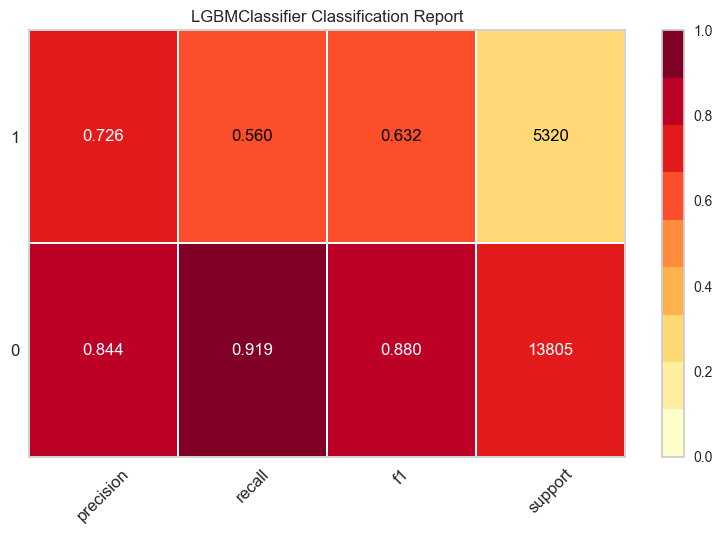

In [510]:
plot_model(estimator=experiment1_model_tuned, plot='class_report')

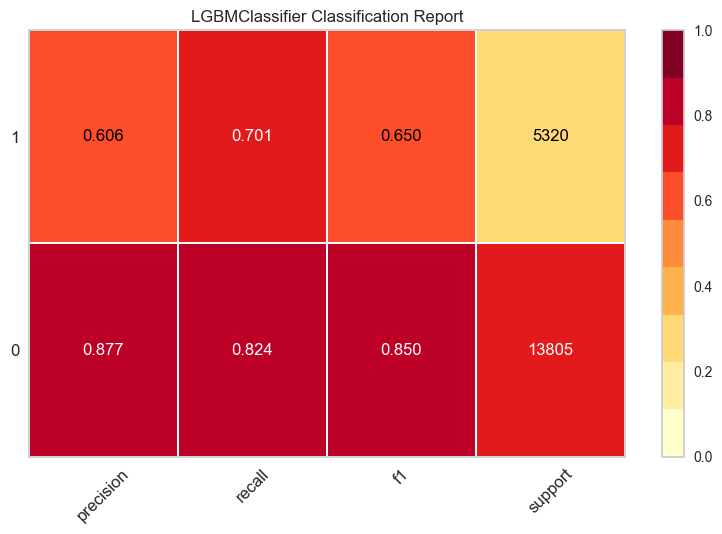

In [512]:
plot_model(estimator=experiment3_model_tuned, plot='class_report')

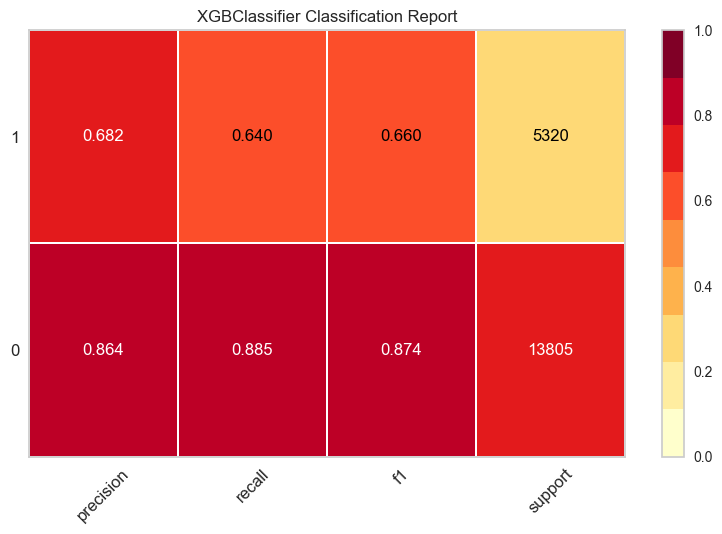

In [516]:
plot_model(estimator=experiment4_model_tuned, plot='class_report')

## Model Evaluation

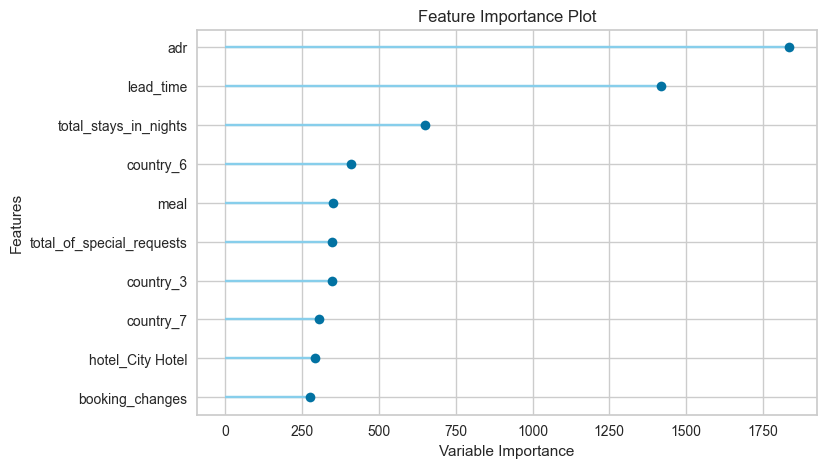

In [514]:
plot_model(estimator=experiment1_model_tuned, plot='feature')

Notes:
* This plot visualize `feature_importances_` attribute provided by the model, to describe the underlying impact of features relative to each other.
    * This attribute is only available when the model is fitted with training data.
    * By using this, user can eliminate weak features or combination of them and re-evaluate to see if the model would fare better during the cross-validation.
* ...

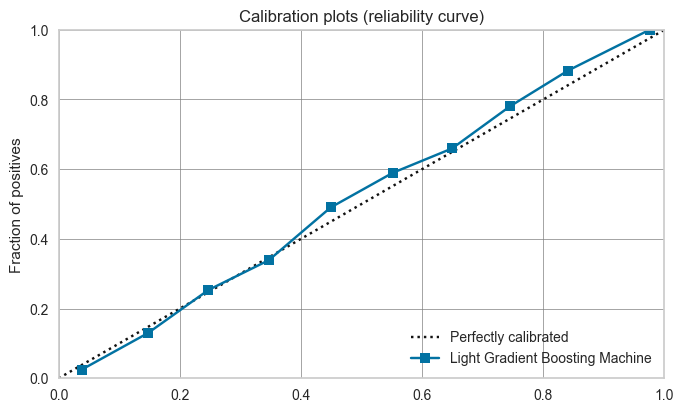

In [515]:
plot_model(estimator=experiment1_model_tuned, plot='calibration')

Notes:
* Calibration plot visualize how well-calibrated the predicted probabilites are, using calibration curve
    * X-axis of this plot shows the average of predicted probability
    * y = probabilities of positive, whether TP or FP?
* Visualization above shows that there are potential for this model to be calibrated
    * ...

In [517]:
# Calibrating model...
experiment1_model_calibrated = experiment1.calibrate_model(estimator=experiment1_model_tuned, method='isotonic', return_train_score=True)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

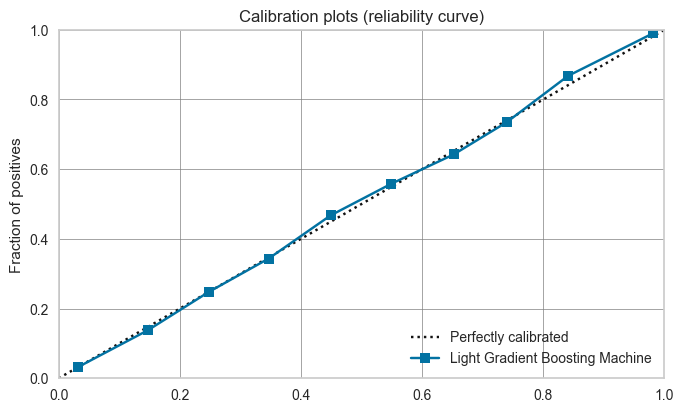

In [518]:
plot_model(estimator=experiment1_model_calibrated, plot='calibration')

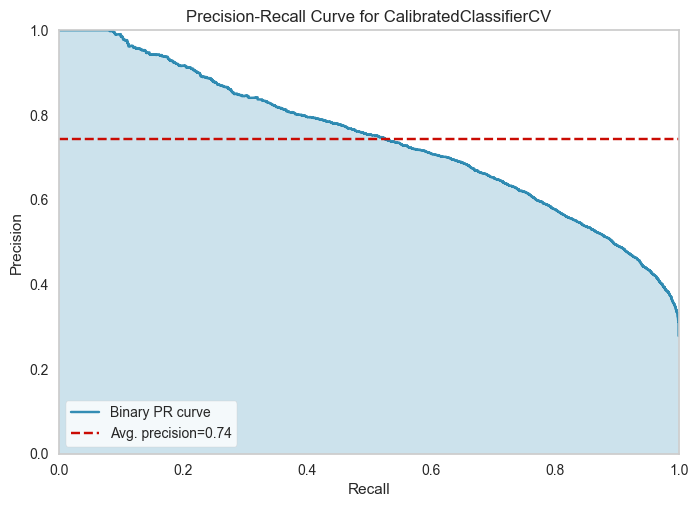

In [519]:
plot_model(estimator=experiment1_model_calibrated, plot='pr')

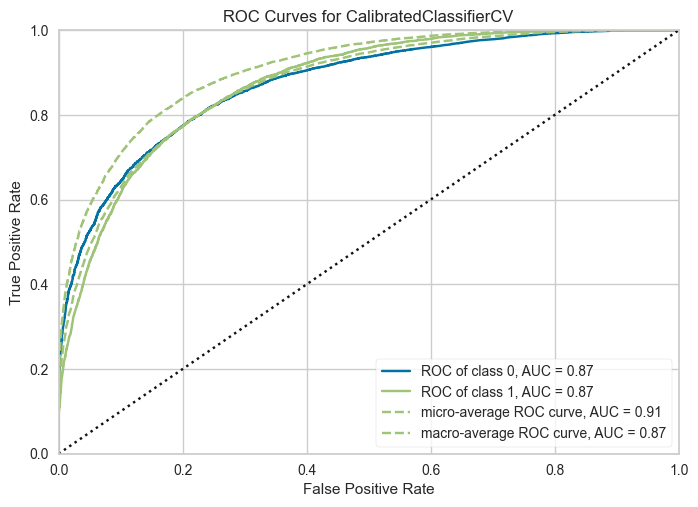

In [524]:
plot_model(estimator=experiment1_model_calibrated, plot='auc')

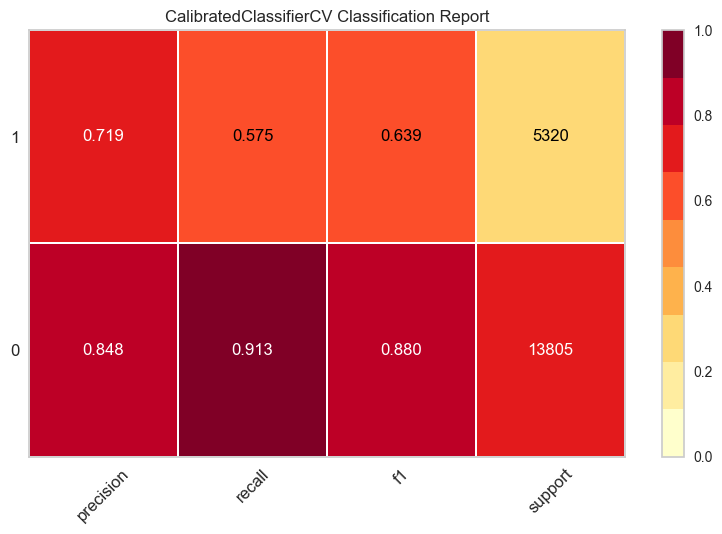

In [520]:
plot_model(estimator=experiment1_model_calibrated, plot='class_report')

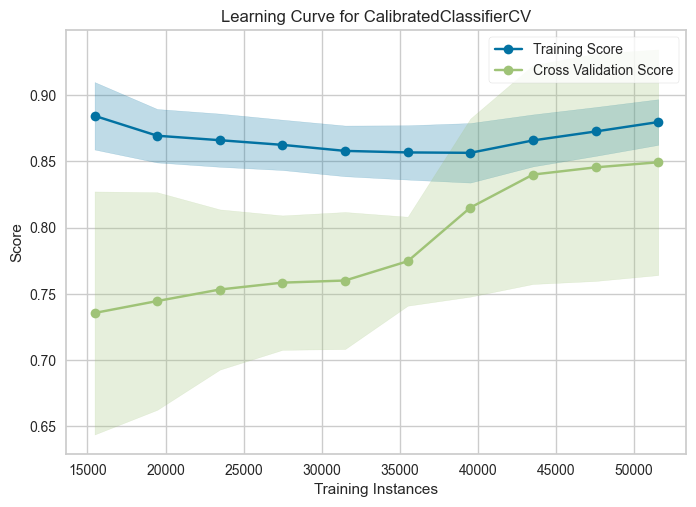

In [521]:
plot_model(estimator=experiment1_model_calibrated, plot='learning')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 767, number of negative: 2088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 2855, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268651 -> initscore=-1.001475
[LightGBM] [Info] Start training from score -1.001475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 767, number of negative: 2088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to rem

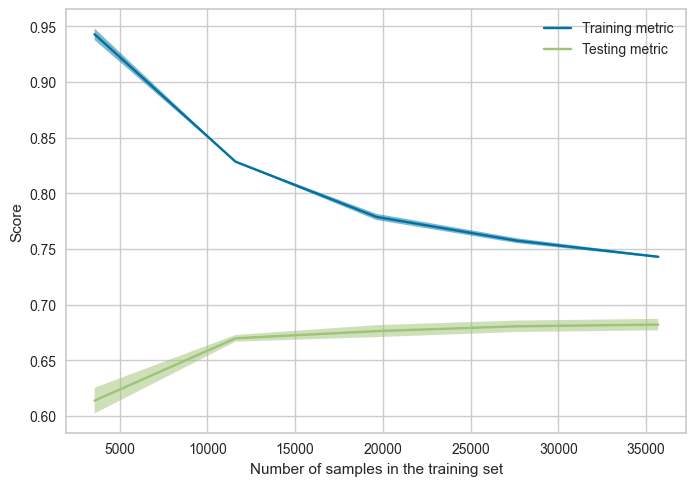

In [522]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import LearningCurveDisplay

fbeta_scorer = make_scorer(score_func=fbeta_score, beta=0.5)
X_train_transformed1, y_train_transformed1 = experiment1.get_config('X_train_transformed'), experiment1.get_config('y_train_transformed')

LearningCurveDisplay.from_estimator(estimator=experiment1_model_calibrated, 
                                    X=X_train_transformed1, 
                                    y=y_train_transformed1, 
                                    scoring=fbeta_scorer,
                                    score_type='both')

plt.show()

In [526]:
X_train_transformed1, X_test_transformed1 = experiment1.get_config('X_train_transformed'), experiment1.get_config('X_test_transformed')
X_train_transformed1

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,...,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
25060,0.0,1.0,-0.078947,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.902913,0.0,-1.0
11976,0.0,1.0,1.228070,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.189320,0.0,0.0
3893,0.0,1.0,0.412281,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.888349,0.0,0.0
35282,1.0,0.0,-0.385965,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.097087,0.0,1.0
3696,0.0,1.0,1.035088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.533981,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49001,1.0,0.0,0.631579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,7.0,0.0,0.0,1.0,0.0,1.472492,0.0,-1.0
21415,0.0,1.0,1.228070,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.843042,1.0,0.0
8878,0.0,1.0,2.280702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.174757,0.0,-1.0
18747,0.0,1.0,-0.429825,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.469256,0.0,0.0


In [527]:
X_test_transformed1

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,...,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
41379,1.0,0.0,0.447368,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.700647,0.0,-1.0
20052,0.0,1.0,-0.412281,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.711974,1.0,0.0
50477,1.0,0.0,1.315789,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.131068,0.0,0.0
30230,0.0,1.0,-0.421053,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.436893,0.0,1.0
58927,1.0,0.0,-0.403509,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.064725,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3982,0.0,1.0,0.771930,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.550162,0.0,-1.0
22403,0.0,1.0,1.184211,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.042071,0.0,0.0
33232,0.0,1.0,0.087719,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.119741,0.0,1.0
24539,0.0,1.0,-0.131579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.990291,1.0,0.0


In [531]:
X_train_transformed1.dtypes

hotel_City Hotel                  float64
hotel_Resort Hotel                float64
lead_time                         float64
arrival_day_type_Weekday          float64
arrival_day_type_Weekend          float64
arrival_date_month_April          float64
arrival_date_month_August         float64
arrival_date_month_December       float64
arrival_date_month_February       float64
arrival_date_month_January        float64
arrival_date_month_July           float64
arrival_date_month_June           float64
arrival_date_month_March          float64
arrival_date_month_May            float64
arrival_date_month_November       float64
arrival_date_month_October        float64
arrival_date_month_September      float64
total_stays_in_nights             float64
total_guests                      float64
meal                                int32
country_0                           int64
country_1                           int64
country_2                           int64
country_3                         

In [528]:
import dice_ml

X_train_transformed1, X_test_transformed1 = experiment1.get_config('X_train_transformed'), experiment1.get_config('X_test_transformed')
X_train_transformed1['is_canceled'] = experiment1.get_config('y_train')
continuous_features_ = [var for var in numeric_vars.drop(columns=['is_canceled', 'total_stays_in_nights', 'total_guests'])]

dice_data = dice_ml.Data(dataframe=X_train_transformed1, continuous_features=continuous_features_, outcome_name='is_canceled')
dice_model = dice_ml.Model(model=experiment1_model_calibrated, backend='sklearn')
dice_instance = dice_ml.Dice(data_interface=dice_data, model_interface=dice_model)
dice_explainer = dice_instance.generate_counterfactuals(query_instances=X_test_transformed1[0:1], total_CFs=5)

with pd.option_context('display.max_columns', None):
    dice_explainer.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: hotel_City Hotel: object, hotel_Resort Hotel: object, arrival_day_type_Weekday: object, arrival_day_type_Weekend: object, arrival_date_month_April: object, arrival_date_month_August: object, arrival_date_month_December: object, arrival_date_month_February: object, arrival_date_month_January: object, arrival_date_month_July: object, arrival_date_month_June: object, arrival_date_month_March: object, arrival_date_month_May: object, arrival_date_month_November: object, arrival_date_month_October: object, arrival_date_month_September: object, total_stays_in_nights: object, total_guests: object, meal: object, country_0: object, country_1: object, country_2: object, country_3: object, country_4: object, country_5: object, country_6: object, country_7: object, distribution_channel_Corporate: object, distribution_channel_Direct: object, distribution_channel_GDS: object, distribution_channel_TA/TO: object, distribution_channel_Undefined: object, reserved_room_type_A: object, reserved_room_type_B: object, reserved_room_type_C: object, reserved_room_type_D: object, reserved_room_type_E: object, reserved_room_type_F: object, reserved_room_type_G: object, reserved_room_type_H: object, reserved_room_type_L: object, deposit_type_No Deposit: object, deposit_type_Non Refund: object, deposit_type_Refundable: object, customer_type_Contract: object, customer_type_Group: object, customer_type_Transient: object, customer_type_Transient-Party: object